# Data Prep and Inspection

Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")

print("Packages successfully imported!")

Importing the data

In [ ]:
data = pd.read_csv("data/data_raw.csv")

print("Data successfully imported!")

### Inspecting Data

In [ ]:
data.head()

In [ ]:
print(f"The dataset has {data.shape[0]} rows")

In [ ]:
assert data['Customer ID'].nunique() == data.shape[0], "There are duplicated Customer IDs"
# No customer duplicates

Checking missing values

In [ ]:
data.isna().sum()

We will remove the two rows with NA's as there's only two.

In [ ]:
data_full = data.dropna()

print(f"The new dataset has {data_full.shape[0]} rows")

Checking for missing data

Inspecting counts and summary stats for cat and numeric vars, respectively

In [ ]:
# Selecting numeric columns
numeric_stats = data_full.describe()

# For categorical columns
categorical_columns = data_full.select_dtypes(include=['object', 'category']).columns
categorical_values = {col: data_full[col].value_counts() for col in categorical_columns}

# Display results
print("Numeric Stats:\n", numeric_stats)
print("\nCategorical Values:")
for col, values in categorical_values.items():
    print(f"\n{col}:\n", values)


Plotting pie charts for the categorical vars

In [ ]:
# Create a 2x2 grid for the pie charts
fig, axes = plt.subplots(2, 2, figsize=(9, 8))

# Flatten the axes array for iter
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    # get value counts for the column
    values = data_full[col].value_counts()
    
    # plot pie chart on the corresponding axis
    axes[i].pie(values, labels=values.index, autopct='%1.1f%%', startangle=140, 
                colors=palette[:len(values)])
    
    # setting the title for each subplot
    axes[i].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    
    # equal aspect ratio ensures circle
    axes[i].axis('equal')

# Adjust layout, prevent overlap
plt.tight_layout()

plt.show()

Categorical variables seem to have very equal distributions, we will now inspect the numeric vars

In [ ]:
numeric_columns = data_full.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop('Customer ID')
# Create a 2x2 grid for the pie charts
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Flatten the axes array for iter
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Plot box plot on the corresponding axis
    sns.boxplot(y=data_full[col], ax=axes[i], color=sns.color_palette("Set2")[i])
    
    # Set the title for each subplot
    axes[i].set_title(f'Box Plot of {col}', fontsize=14, fontweight='bold')

# Adjust layout, prevent overlap
plt.tight_layout()

plt.show()

In [ ]:
# Create a 2x2 grid for the histogram
fig, axes = plt.subplots(2, 3, figsize=(9, 8))

# Flatten the axes array for iter
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Plot histogram on the corresponding axis
    axes[i].hist(data_full[col], bins=20, color=sns.color_palette("Set2")[i], edgecolor='black')
    
    # Set the title for each subplot
    axes[i].set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
    
    # Set labels
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Adjust layout, prevent overlap
plt.tight_layout()

plt.show()

# Cleaning the data

While the data is cleaned (in the proper structure), we will need to one-hot encode the cat vars for modelling

In [96]:
from sklearn.preprocessing import LabelEncoder

data_encoded = data_full.copy()
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Initialize a dictionary to store the encoders
label_encoders = {}

# Apply label encoding to each categorical column
for col in data_encoded.select_dtypes(include=['object', 'category', 'bool']).columns:
    data_encoded[col] = label_encoder.fit_transform(data_encoded[col])
    
    # Save the encoder mapping
    label_encoders[col] = {class_label: int(value) for class_label, value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}

    print(f"Encoded {col}: {label_encoders[col]}")

# reverse_mapping = {v: k for k, v in label_encoders[''].items()}
data_encoded.head()

# saving the encoded data
data_encoded.to_csv('data/data_encoded.csv')


Encoded Gender: {'Female': 0, 'Male': 1}
Encoded City: {'Chicago': 0, 'Houston': 1, 'Los Angeles': 2, 'Miami': 3, 'New York': 4, 'San Francisco': 5}
Encoded Membership Type: {'Bronze': 0, 'Gold': 1, 'Silver': 2}
Encoded Discount Applied: {np.False_: 0, np.True_: 1}
Encoded Satisfaction Level: {'Neutral': 0, 'Satisfied': 1, 'Unsatisfied': 2}


Now, we will normalise the numerical values in order to ensure equal contribution

In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_normal = data_encoded.copy()
colnames = data_encoded.columns

data_normal[numeric_columns] = scaler.fit_transform(data_normal[numeric_columns])

data_normal.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,0,-0.939761,4,1,0.754230,0.330381,0.996757,1,-0.120022,1
1,102,1,0.086720,2,2,-0.186319,-0.394236,0.132172,0,-0.640260,0
2,103,0,1.934386,0,0,-0.933192,-0.877314,-1.078247,1,1.143413,2
3,104,1,-0.734465,5,1,1.751261,1.538076,1.169674,0,-1.086179,1
4,105,1,-1.350354,3,2,-0.352721,0.088842,-0.040745,1,2.109570,2


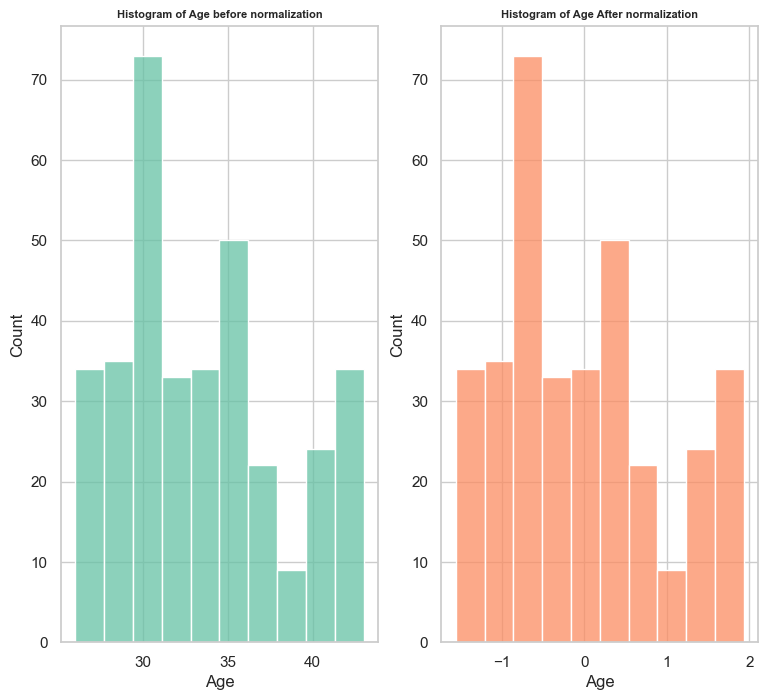

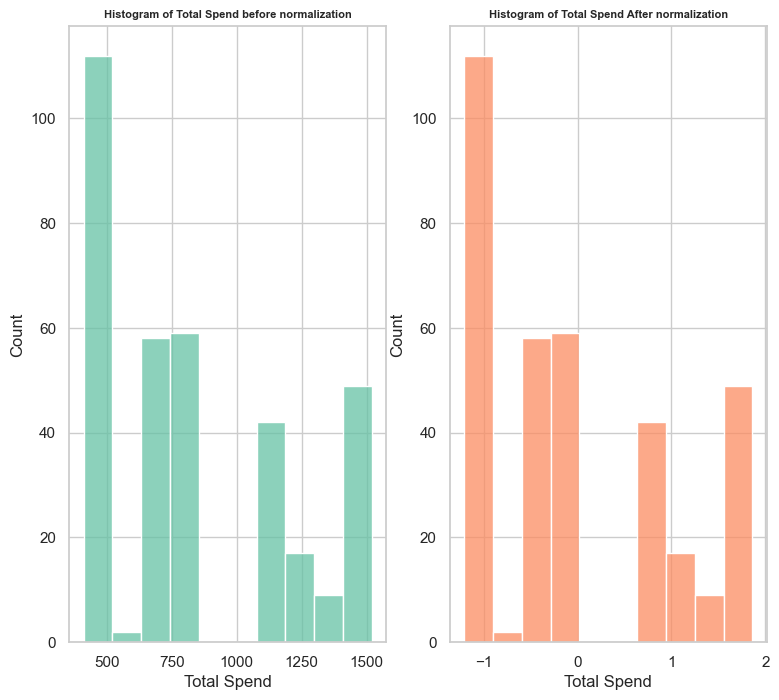

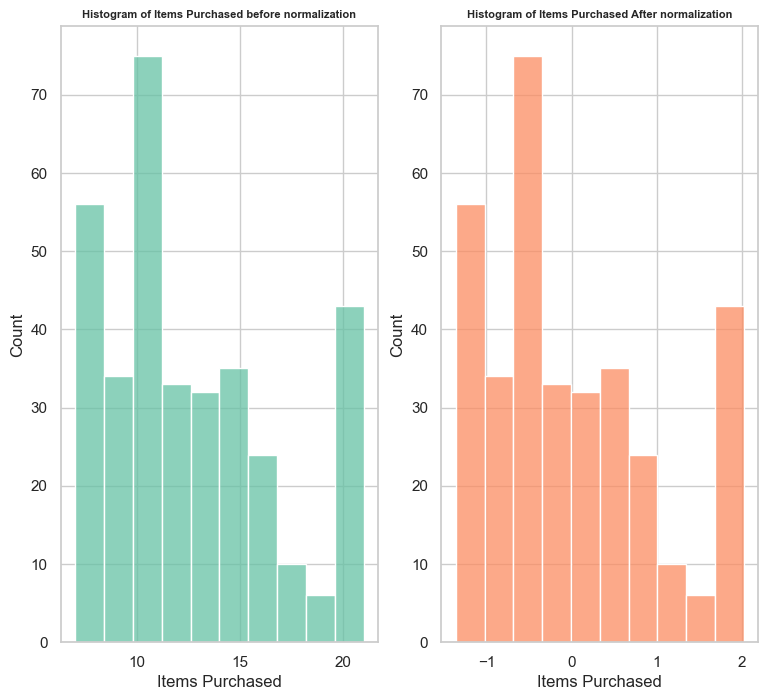

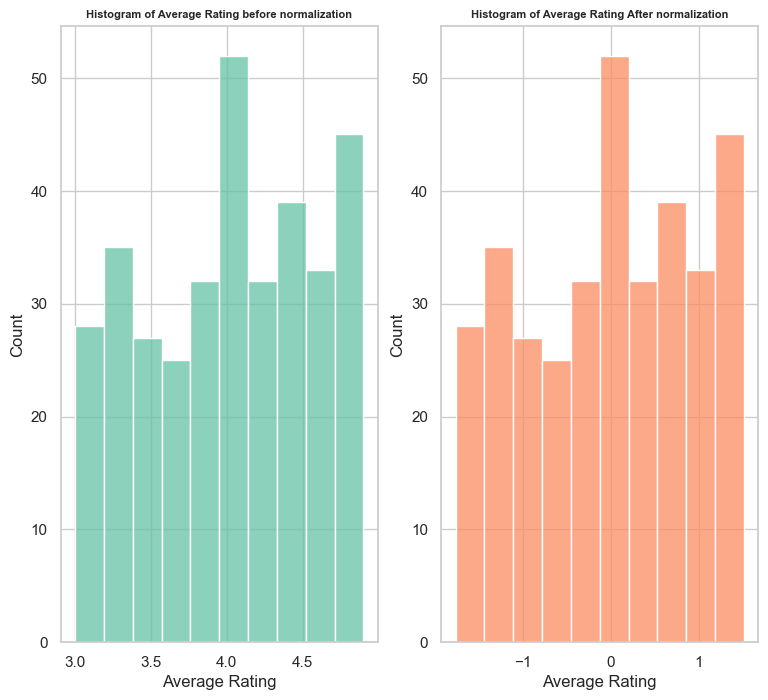

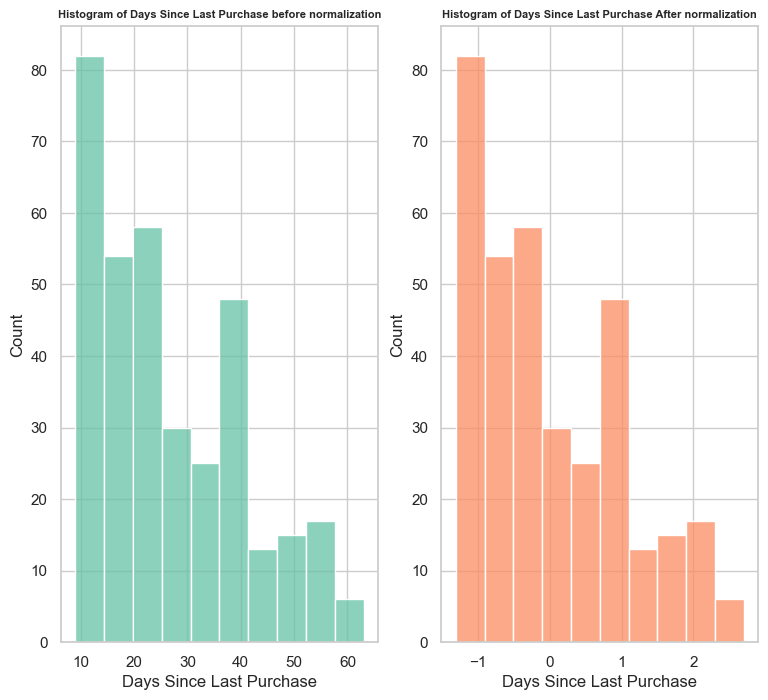

In [98]:
# Comparing distributions of normalised numeric vars, they should be identical
for col in numeric_columns:
    fig, axes = plt.subplots(1, 2, figsize=(9, 8))
    sns.histplot(data_encoded[col], ax = axes[0], color=sns.color_palette("Set2")[0])
    axes[0].set_title(f'Histogram of {col} before normalization', fontsize=8, fontweight='bold')
    sns.histplot(data_normal[col], ax= axes[1], color=sns.color_palette("Set2")[1])
    axes[1].set_title(f'Histogram of {col} After normalization', fontsize=8, fontweight='bold')
    plt.show()

In [99]:
# Saving normalised data
data_normal.to_csv('data/data_normal.csv')

### Comparing Variables

For comparison of variables, we will continue with the raw data as it contains the proper categorical variables, and actual numerical values.

Using Pairplot to compare variables

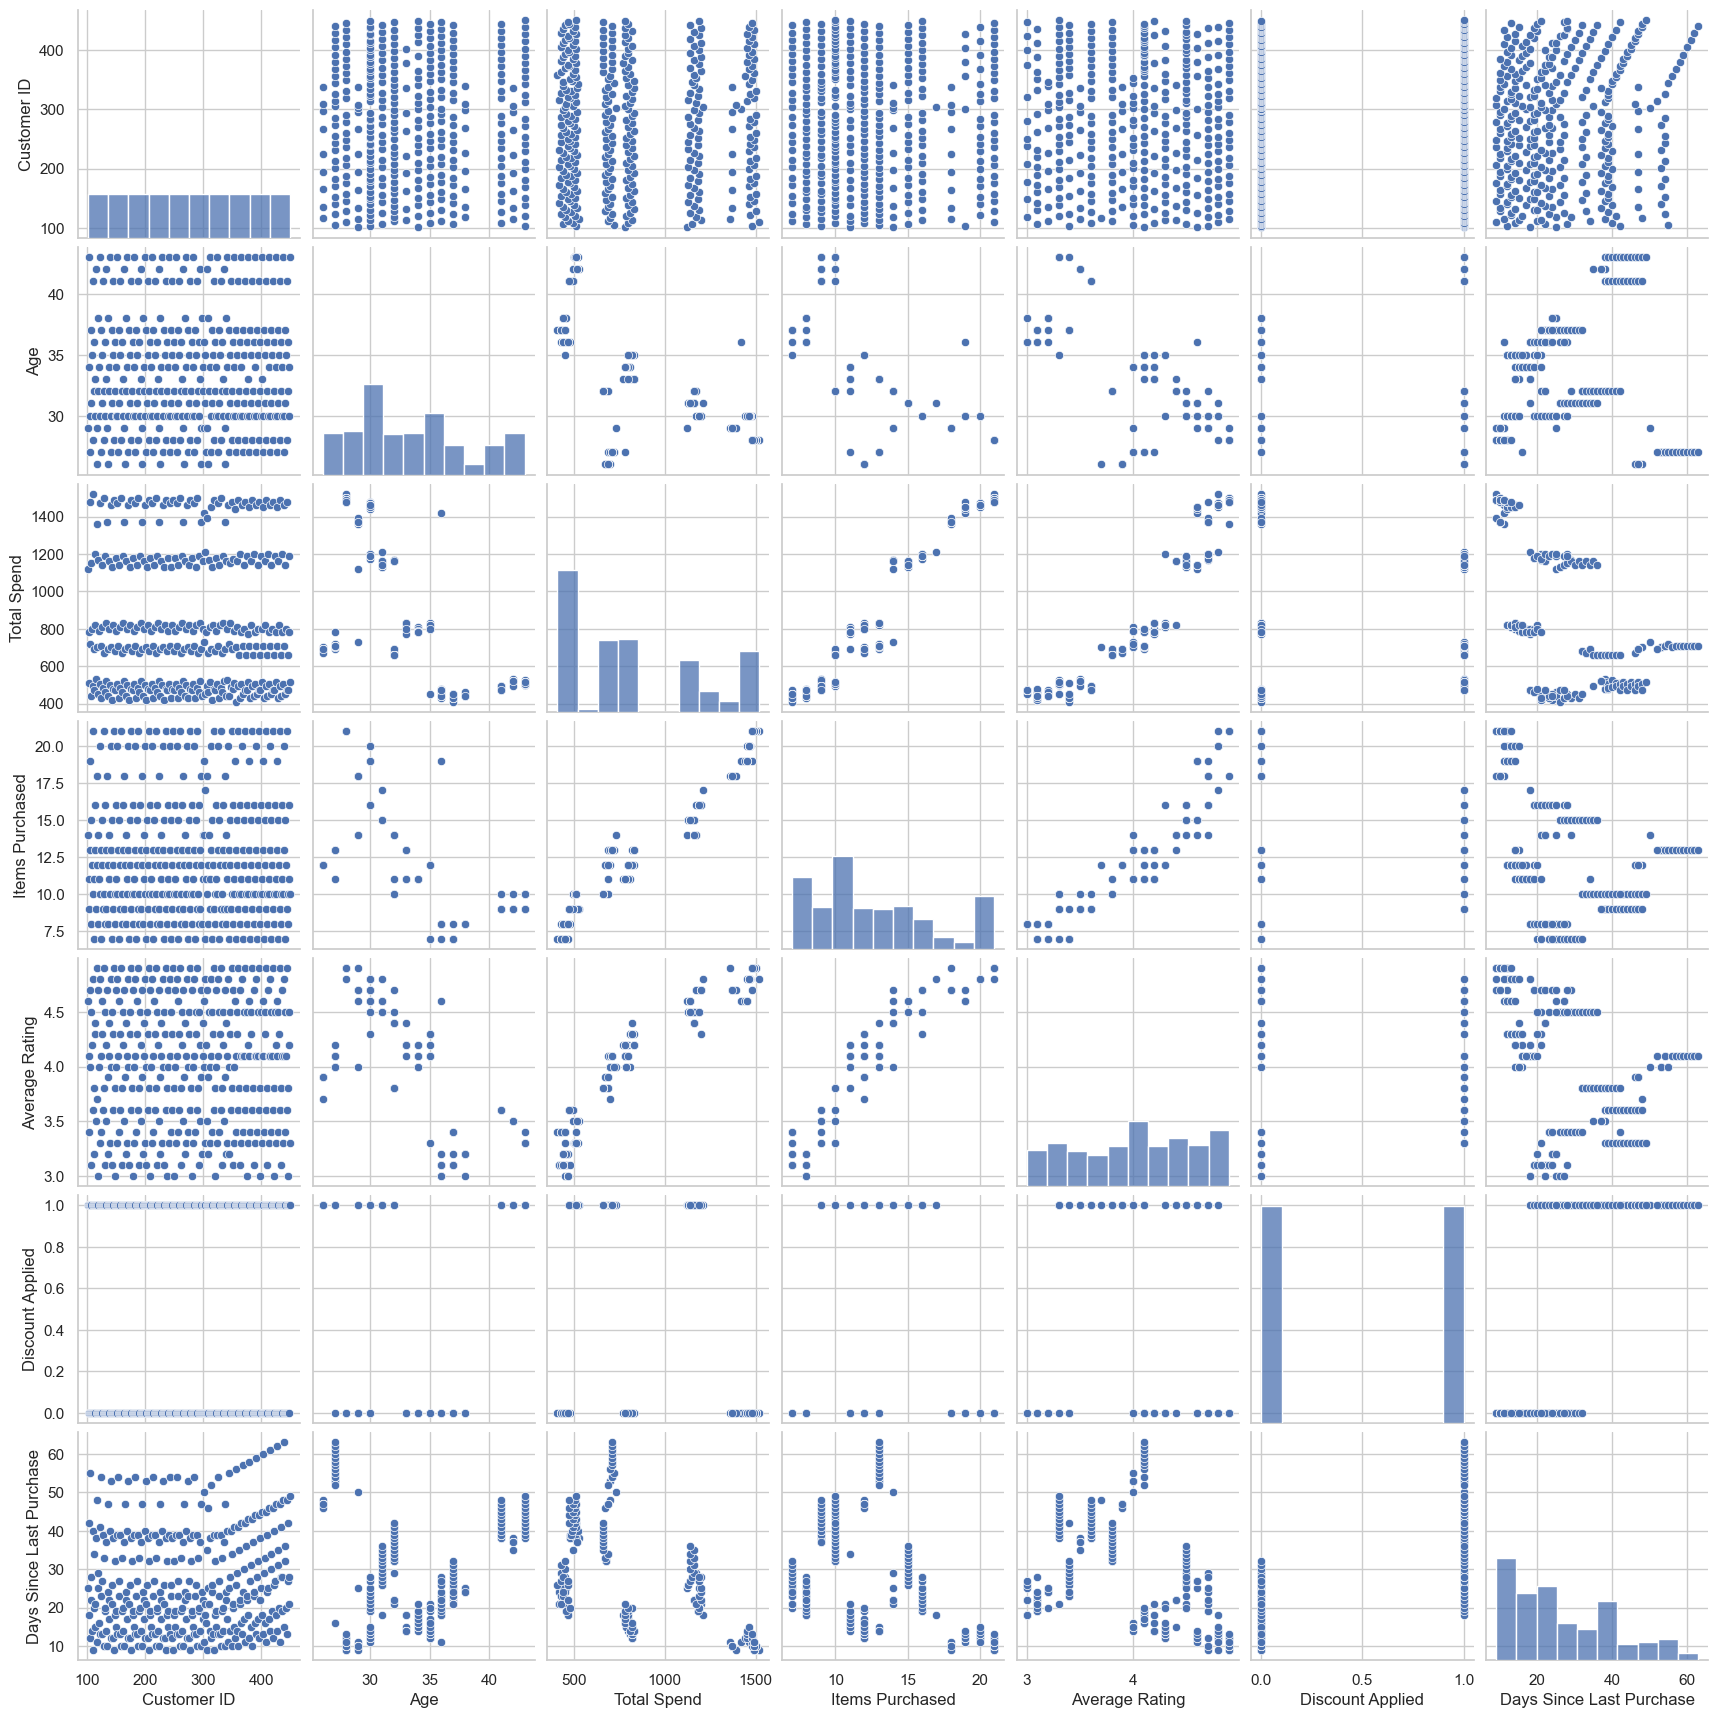

In [100]:
sns.pairplot(data)
plt.show()


This is a bit crowded, let's try something else!

We'll compare the correlations of each variable with each other! Using this, we can discern which variables we want to take a closer look at.

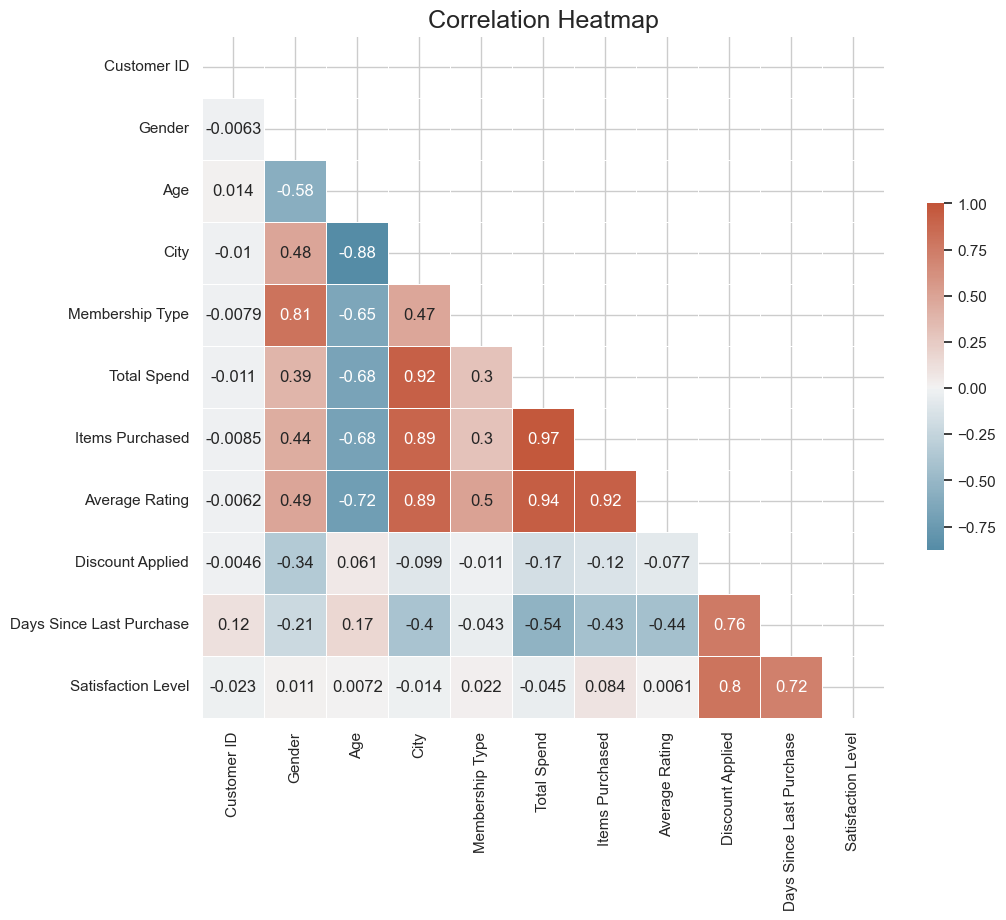

In [101]:
# Compute the correlation matrix
corr = data_normal.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title("Correlation Heatmap", fontsize=18)
plt.show()

First things first, obviously customer ID isn't related to any variable, and items purchased is highly correlated with items bought. One notable insight from this plot is Total Spend being so highly correlated with City, we'll investigate this further!

Overall, we're gonna take the relationships with a correlation of r ≥ ±0.7 to investigate further.

In [102]:
# Calculate the correlation matrix
corr_matrix = data_encoded.corr().abs()

# Set the lower triangle and the diagonal of the matrix to 0 to avoid double-counting and self-correlation
corr_matrix.values[np.tril_indices_from(corr_matrix)] = 0

# Find all pairs where correlation is greater than or equal to 0.7
high_corr_pairs = corr_matrix[corr_matrix >= 0.7].stack().sort_values(ascending=False)

# Display the pairs
print("Highly correlated pairs with r >= ±0.7:\n")
for index, value in high_corr_pairs.items():
    print(f"{index[0]:<25}~ {index[1]:<30}--> r = {value:.2f}")

Highly correlated pairs with r >= ±0.7:

Total Spend              ~ Items Purchased               --> r = 0.97
Total Spend              ~ Average Rating                --> r = 0.94
Items Purchased          ~ Average Rating                --> r = 0.92
City                     ~ Total Spend                   --> r = 0.92
City                     ~ Items Purchased               --> r = 0.89
City                     ~ Average Rating                --> r = 0.89
Age                      ~ City                          --> r = 0.88
Gender                   ~ Membership Type               --> r = 0.81
Discount Applied         ~ Satisfaction Level            --> r = 0.80
Discount Applied         ~ Days Since Last Purchase      --> r = 0.76
Age                      ~ Average Rating                --> r = 0.72
Days Since Last Purchase ~ Satisfaction Level            --> r = 0.72


Visualizing Total Spend and Items Purchased (Numerical-Numerical)


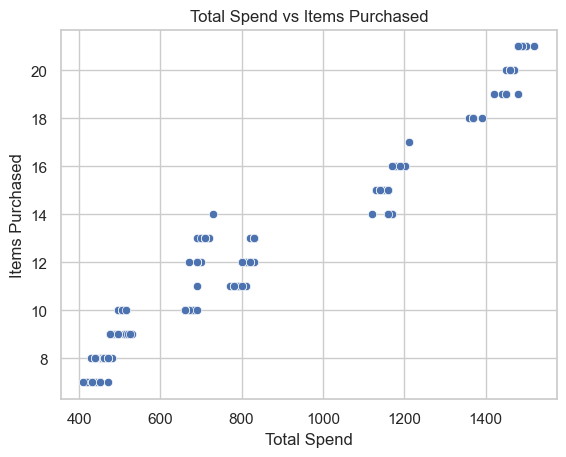

Visualizing Total Spend and Average Rating (Numerical-Numerical)


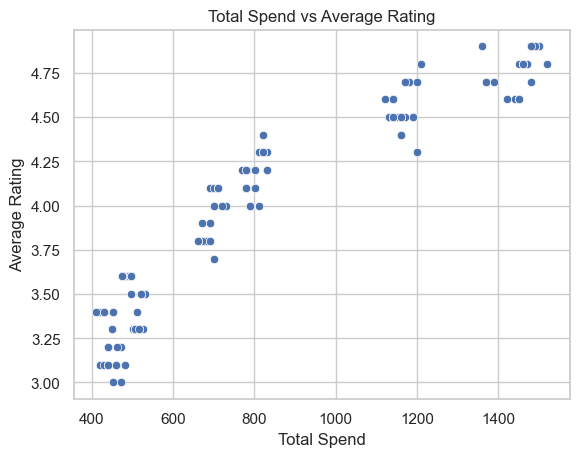

Visualizing Items Purchased and Average Rating (Numerical-Numerical)


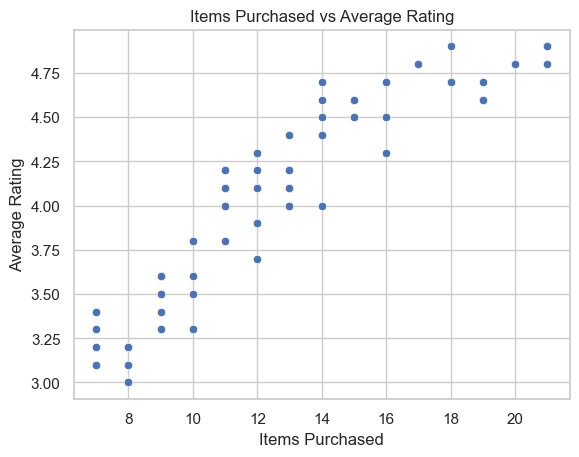

Visualizing City and Total Spend (Categorical-Numerical)


/var/folders/zy/5chfsfsd461fc9x38r61w2xr0000gn/T/ipykernel_14365/2046037643.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var1, y=var2, data=data, palette='Set2')


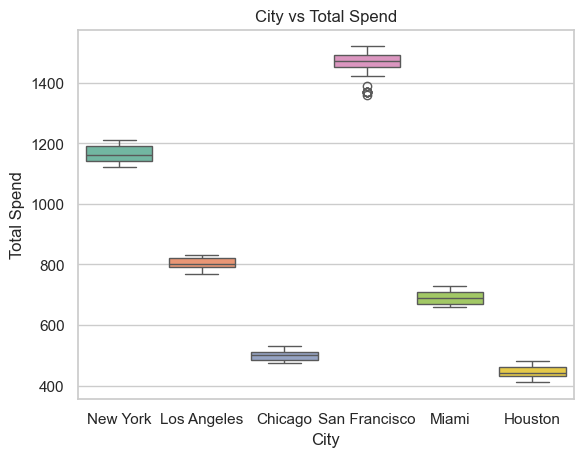

Visualizing City and Items Purchased (Categorical-Numerical)


/var/folders/zy/5chfsfsd461fc9x38r61w2xr0000gn/T/ipykernel_14365/2046037643.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var1, y=var2, data=data, palette='Set2')


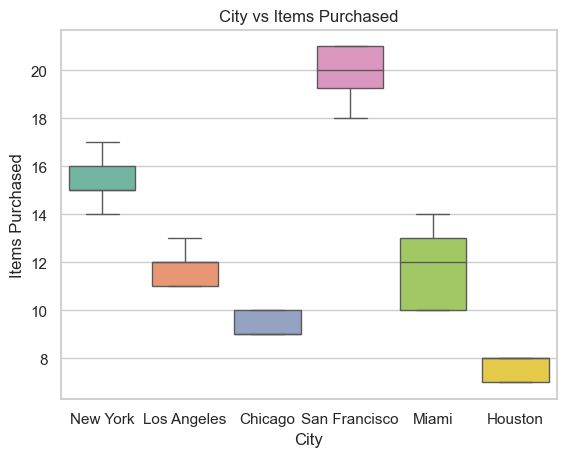

Visualizing City and Average Rating (Categorical-Numerical)


/var/folders/zy/5chfsfsd461fc9x38r61w2xr0000gn/T/ipykernel_14365/2046037643.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var1, y=var2, data=data, palette='Set2')


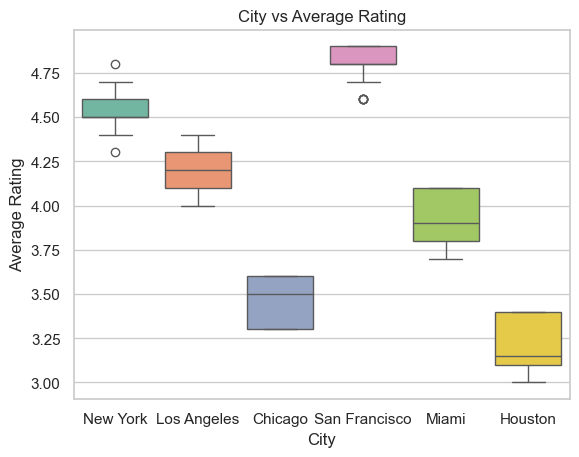

Visualizing Age and City (Categorical-Numerical)


/var/folders/zy/5chfsfsd461fc9x38r61w2xr0000gn/T/ipykernel_14365/2046037643.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var2, y=var1, data=data, palette='Set2')


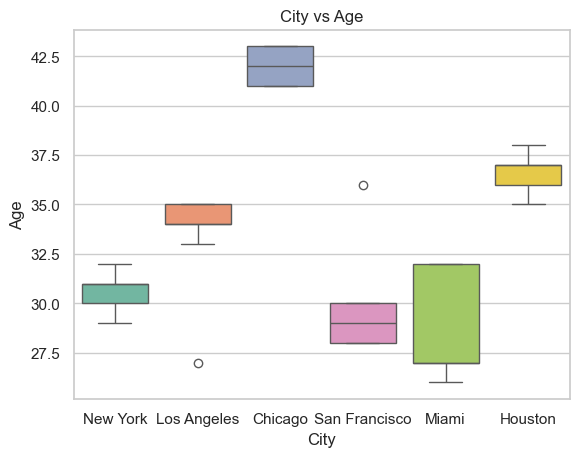

Visualizing Gender and Membership Type (Categorical-Categorical)


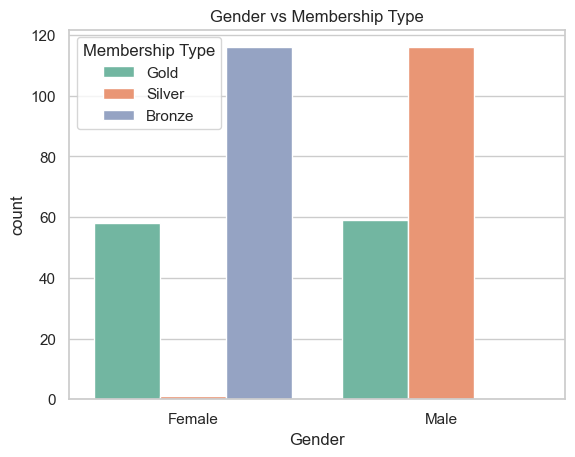

Visualizing Age and Average Rating (Numerical-Numerical)


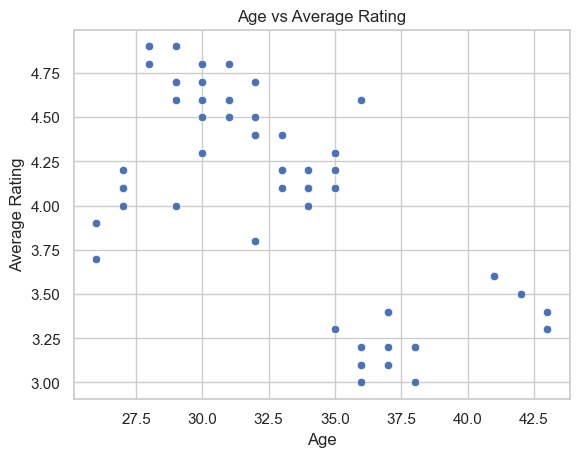

Visualizing Days Since Last Purchase and Satisfaction Level (Categorical-Numerical)


/var/folders/zy/5chfsfsd461fc9x38r61w2xr0000gn/T/ipykernel_14365/2046037643.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var2, y=var1, data=data, palette='Set2')


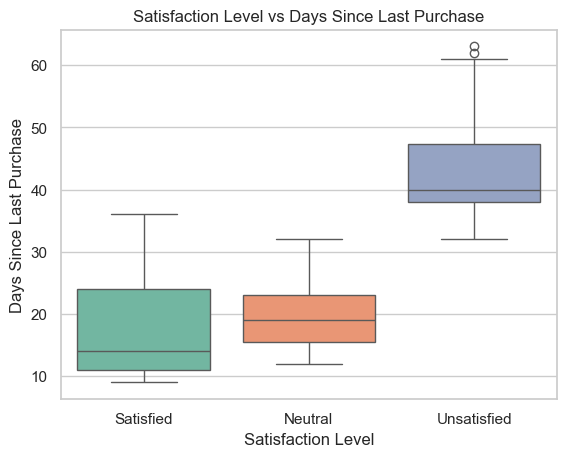

In [103]:
for index, value in high_corr_pairs.items():
    var1 = index[0]
    var2 = index[1]
    # We'll need to go through each possible scenario (Numerical-numerical, numerical-categorical, categorical-categorical)
    # Scenario 1: Both variables are categorical
    if var1 in categorical_columns and var2 in categorical_columns:
        print(f"Visualizing {var1} and {var2} (Categorical-Categorical)")
        sns.countplot(x=var1, hue=var2, data=data, palette='Set2')
        plt.title(f'{var1} vs {var2}')
        plt.show()
    
    # Scenario 2: Both variables are numerical
    elif var1 in numeric_columns and var2 in numeric_columns:
        print(f"Visualizing {var1} and {var2} (Numerical-Numerical)")
        sns.scatterplot(x=var1, y=var2, data=data)
        plt.title(f'{var1} vs {var2}')
        plt.show()
    
    # Scenario 3: One variable is categorical, the other is numerical
    elif (var1 in numeric_columns and var2 in categorical_columns) or (var1 in categorical_columns and var2 in numeric_columns):
        print(f"Visualizing {var1} and {var2} (Categorical-Numerical)")
        
        # If var1 is categorical and var2 is numerical
        if var1 in categorical_columns:
            sns.boxplot(x=var1, y=var2, data=data, palette='Set2')
            plt.title(f'{var1} vs {var2}')
            plt.show()
        
        # If var1 is numerical and var2 is categorical
        else:
            sns.boxplot(x=var2, y=var1, data=data, palette='Set2')
            plt.title(f'{var2} vs {var1}')
            plt.show()

## Reviewing each visualisation
**1. Total Spent ~ Items Purchased:** This relationship is clear, and obvious. Buy more, spend more! <br>
**2. Total Spent ~ Average Rating:** Customers who really love the company are bound to spend more! <br>
**3. Items Purchased ~ Average Rating:** This becomes interesting because of the relationship between Total Spent and Items
Purchased. All three of these variables are bound to be highly correlated, but there's questions of which ranks highest in importance: <br>

- Do customers who spend more feel more of a duty to like the brand, and thus keep buying more items?
- Does purchasing more items increase the likelihood of buying things you like, thus making you spend more?
- Or, does their rating of the company keep them coming back to buy more items and spend more money?

> Essentially, these are the same question in a different order; three things can be true at once! When modelling, we will swap out these variables to determine influence.

**4. City ~ Total Spent**  
**5. City ~ Items Purchased**  
**6. City ~ Average Rating**  

> We're seeing those same three variables again: Total Spend, Items Purchased, Average Rating. But now, it's a lot less obvious. City could be influencing one of those variables, impacting the other two.

> Is the demographic in San Francisco more in line with the culture of the brand, and vice versa for Chicago?

**7. City ~ Age:** Another City relationship, but interestingly, Age is not highly correlated with either Total Spent or Items Purchased. It would seem as though the cities with higher Average Ratings (Visualization 6) have lower ages of customers. This will need to be looked at further.  
**8. Gender ~ Membership Type:**  For this to be investigates we would need to understand each membership type, but there does seem to be very different Membership Types between Gender.<br>
**9. Age ~ Average Rating:**  It seems as though as age increases, average rating decreases. This coincides slightly with City ~ Age<br>
**10. Satisfaction Level ~ Average Rating:** These metrics coincide heavily, so this makes sense.

## Multicollinearity Check 
Highly correlated features can lead to multicollinearity, which can negatively impact some machine learning models.
Since we plan on building predictive models, we will assess multicollinearity and decide whether to drop or combine some of these features.

We will navigate through a few Feature Engineering and Dimensionality Reduction techniques to navigate which feels right for this project.


### Variance Inflation Factor

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant column to calculate VIF
X = add_constant(data_normal[numeric_columns])
# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif = vif.sort_values('VIF', ascending=False)

print(vif)

                   Variable        VIF
2               Total Spend  42.068863
3           Items Purchased  25.632562
4            Average Rating  10.304851
5  Days Since Last Purchase   2.241512
1                       Age   2.230155
0                     const   1.000000


Total Spend has very high correlation with other variables, to the point of being problematic. So we will drop that variable, and run this code again.

In [105]:
# Add a constant column to calculate VIF
numeric_columns_1 = numeric_columns.drop('Total Spend')
X = add_constant(data_normal[numeric_columns_1])
# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif = vif.sort_values('VIF', ascending=False)

print(vif)

                   Variable       VIF
3            Average Rating  7.685117
2           Items Purchased  6.706824
1                       Age  2.223715
4  Days Since Last Purchase  1.314504
0                     const  1.000000


Dropping Total Spend alone was enough to reduce much of the collinearity of the other variables. This is not enough though, Average Rating is still quite high, we will remove this and try again.

In [106]:
# Add a constant column to calculate VIF
numeric_columns_2 = numeric_columns_1.drop('Average Rating')
X = add_constant(data_normal[numeric_columns_2])
# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif = vif.sort_values('VIF', ascending=False)

print(vif)

                   Variable       VIF
2           Items Purchased  2.307314
1                       Age  1.946257
3  Days Since Last Purchase  1.263267
0                     const  1.000000


While at first it would seem as though we should have dropped Total Spend, Average Rating, AND Items Purchased, it's evident that only removing the first two was enough to get the collinearity to a reasonable point.

### Principal Component Analysis

In [107]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Apply PCA
pca = PCA(n_components=5)  # Adjust components as needed
pca_data = pca.fit_transform(scaled_data)

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

Explained variance ratio: [0.7422501  0.17201217 0.06667043 0.01604483 0.00302247]


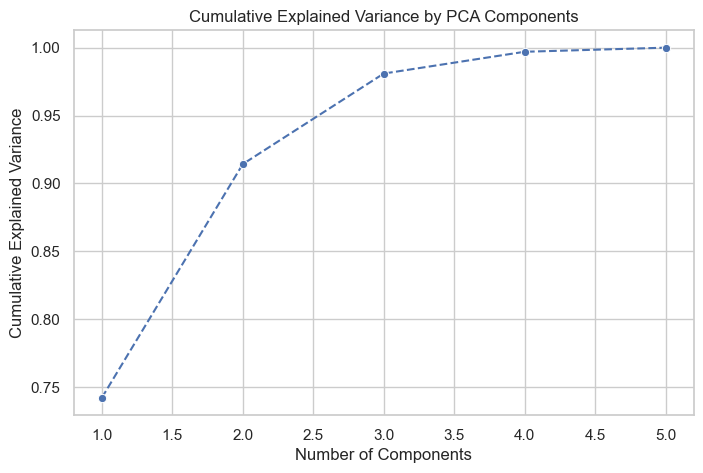

In [108]:
# Cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
sns.lineplot(x= range(1, len(cumulative_variance) + 1), y =cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

We see Cumulative Explained Variance reaching 0.9 at 2 componenets; however, component 3 is >0.05, so we will keep that in with a total Cumulative Explained Variance of 98.07%

In [109]:
# Apply PCA
pca = PCA(n_components=3)  # Adjust components as needed
pca_data = pca.fit_transform(scaled_data)

print(f'Explained variance ratio: {pca.explained_variance_ratio_}\n')
print("PCA Data (first three rows):\n",pca_data[:3])

Explained variance ratio: [0.7422501  0.17201217 0.06667043]

PCA Data (first three rows):
 [[ 1.4704333   0.4192768  -0.24603101]
 [-0.06621509 -0.60449853 -0.3403907 ]
 [-2.54246702 -0.02676845  1.15430368]]


The goal of the model wil